In [1]:
!pip install transformers datasets evaluate transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 8.5 MB/s 
     |████████████████████████████████| 451 kB 55.9 MB/s 
     |████████████████████████████████| 72 kB 1.7 MB/s 
     |████████████████████████████████| 7.6 MB 51.1 MB/s 
     |████████████████████████████████| 182 kB 78.3 MB/s 
     |████████████████████████████████| 212 kB 74.5 MB/s 
     |████████████████████████████████| 132 kB 80.8 MB/s 
     |████████████████████████████████| 127 kB 79.0 MB/s 
     |████████████████████████████████| 1.3 MB 68.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# Loading our .jsonl file into a Hugging Face dataset format
from datasets import load_dataset
dataset = load_dataset("json", data_files="annotated_data.jsonl")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-40ab6dc6acfde962/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Seeing what our dataset currently looks like
dataset

DatasetDict({
    train: Dataset({
        features: ['text', '_input_hash', '_task_hash', 'spans', 'meta', 'tokens', '_view_id', 'answer', '_timestamp'],
        num_rows: 82
    })
})

In [4]:
# Removing unnecessary columns
dataset = dataset.remove_columns(["text", "_input_hash", "_task_hash", "meta", "_view_id", "answer", "_timestamp"])

In [5]:
# Our dataset now looks like this
dataset

DatasetDict({
    train: Dataset({
        features: ['spans', 'tokens'],
        num_rows: 82
    })
})

In [6]:
print("Example span:", dataset["train"][0]["spans"][0])
print("Example token:", dataset["train"][0]["tokens"][0])

Example span: {'start': 24, 'end': 44, 'token_start': 4, 'token_end': 6, 'label': 'AGENT', 'text': None, 'pattern': None}
Example token: {'text': 'The', 'start': 0, 'end': 3, 'id': 0, 'ws': True}


In [7]:
# The thing we currently call "dataset" is actually a DatasetDict object
actual_dataset = dataset["train"]
actual_dataset

Dataset({
    features: ['spans', 'tokens'],
    num_rows: 82
})

In [8]:
# Create train and test split
new_dataset_dict = actual_dataset.train_test_split(test_size=0.1)

In [9]:
new_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['spans', 'tokens'],
        num_rows: 73
    })
    test: Dataset({
        features: ['spans', 'tokens'],
        num_rows: 9
    })
})

# Data preprocessing

In [10]:
id2label = {
    0: "O",
    1: "B-AGENT",
    2: "I-AGENT",
    3: "B-TASK",
    4: "I-TASK"
}

label2id = {
    "O": 0,
    "B-AGENT": 1,
    "I-AGENT": 2,
    "B-TASK": 3,
    "I-TASK": 4
}

In [11]:
def add_labels_and_tokens_to_dataset (example):

  # Create the "labels" list
  labels = []

  for token in example["tokens"]:
    # Set a flag to indicate whether the token is within a span
    within_span = False
    for span in example["spans"]:
      # Check if the current token is within the span
      if span["token_start"] <= token["id"] <= span["token_end"]:
        # Set the flag to True because the token is within a span
        within_span = True
        if span["token_start"] == token["id"]:
          # The token is the beginning of the span, so it should have the "B-" prefix
            labels.append(1 if span["label"] == "AGENT" else 3)
            break
        else:
          # The token is within the span, but not at the beginning, so it should have the "I-" prefix
          labels.append(2 if span["label"] == "AGENT" else 4)
          break
    # If the token is not within any of the spans, append the default 0 value
    if not within_span:
      labels.append(0)

  example["labels"] = labels
  example["tokens"] = [token["text"] for token in example["tokens"]]

  return example

In [12]:
updated_dataset_dict = new_dataset_dict.map(add_labels_and_tokens_to_dataset)

  0%|          | 0/73 [00:00<?, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ex/s]

In [13]:
updated_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['spans', 'tokens', 'labels'],
        num_rows: 73
    })
    test: Dataset({
        features: ['spans', 'tokens', 'labels'],
        num_rows: 9
    })
})

In [14]:
# We don't need the spans column anymore
updated_dataset_dict = updated_dataset_dict.remove_columns("spans")

In [15]:
updated_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 73
    })
    test: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 9
    })
})

In [16]:
print("Example tokens:", updated_dataset_dict["train"][0]["tokens"][:13])
print("Example labels:", updated_dataset_dict["train"][0]["labels"][:13])

Example tokens: ['The', 'process', 'starts', 'when', 'a', 'job', 'seeker', 'begins', 'their', 'search', 'for', 'a', 'job']
Example labels: [0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 4, 4, 4]


In [17]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:
# Tokenization example
inputs = tokenizer(updated_dataset_dict["train"][4]["tokens"], is_split_into_words=True)

In [19]:
print(inputs.tokens()[:10])
print(inputs.tokens()[60:70])
print(inputs.tokens()[120:])

['[CLS]', 'The', 'process', 'starts', 'when', 'an', 'individual', 'applies', 'for', 'a']
['government', 'department', 'will', 'issue', 'a', 'work', 'permit', '.', 'The', 'individual']
[]


In [20]:
print(inputs.word_ids()[:10])
print(inputs.word_ids()[60:70])
print(inputs.word_ids()[120:])

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
[]


In [21]:
# After tokenization, our labels don't align with the tokens anymore
print("Labels lenght:", len(updated_dataset_dict["train"][4]["labels"]))
print("Tokens lenght before tokenization:", len(updated_dataset_dict["train"][4]["tokens"]))
print("Tokens lenght after tokenization:", len(inputs.tokens()))

Labels lenght: 118
Tokens lenght before tokenization: 118
Tokens lenght after tokenization: 120


In [22]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [23]:
labels = updated_dataset_dict["train"][4]["labels"]
word_ids = inputs.word_ids()
print("Old labels (first 10):", labels[:10])
print("New labels (first 10):", align_labels_with_tokens(labels, word_ids)[:10])

Old labels (first 10): [0, 0, 0, 0, 1, 2, 3, 4, 4, 4]
New labels (first 10): [-100, 0, 0, 0, 0, 1, 2, 3, 4, 4]


In [24]:
print("Old labels length:", len(labels))
print("New labels length:", len(align_labels_with_tokens(labels, word_ids)))

Old labels length: 118
New labels length: 120


In [25]:
# Our tokens and our labels are now aligned
example = inputs.tokens()[53:66]
old_labels = list(map(lambda x: id2label[x], labels[53:66]))
new_labels = list(map(lambda x: id2label[x], align_labels_with_tokens(labels, word_ids)[53:66])) 
print("Tokenized example:", example)
print("Old, unaligned labels:", old_labels)
print("New, aligned labels:", new_labels)

Tokenized example: ['individual', 'does', 'meet', 'the', 'criteria', ',', 'the', 'government', 'department', 'will', 'issue', 'a', 'work']
Old, unaligned labels: ['O', 'O', 'O', 'O', 'O', 'B-AGENT', 'I-AGENT', 'I-AGENT', 'O', 'B-TASK', 'I-TASK', 'I-TASK', 'I-TASK']
New, aligned labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B-AGENT', 'I-AGENT', 'I-AGENT', 'O', 'B-TASK', 'I-TASK', 'I-TASK']


In [26]:
# A function to tokenize the whole dataset and align the labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["labels"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [27]:
# Tokenize the whole dataset
tokenized_datasets = updated_dataset_dict.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=updated_dataset_dict["train"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 73
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9
    })
})

In [29]:
print("Labels:", tokenized_datasets["train"][0]["labels"][:10])
print("Input IDs:", tokenized_datasets["train"][0]["input_ids"][:10])
print("Token type IDs:", tokenized_datasets["train"][0]["token_type_ids"][:10])
print("Attention mask:", tokenized_datasets["train"][0]["attention_mask"][:10])

Labels: [-100, 0, 0, 0, 0, 1, 2, 2, 2, 3]
Input IDs: [101, 1109, 1965, 3816, 1165, 170, 2261, 5622, 1200, 3471]
Token type IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [30]:
print("Labels length:", len(tokenized_datasets["train"][0]["labels"]))
print("Input IDs length:", len(tokenized_datasets["train"][0]["input_ids"]))

Labels length: 192
Input IDs length: 192


In [31]:
# The samples have various lengths
print(len(tokenized_datasets["train"][0]["labels"]))
print(len(tokenized_datasets["train"][1]["labels"]))
print(len(tokenized_datasets["train"][2]["labels"]))

192
64
115


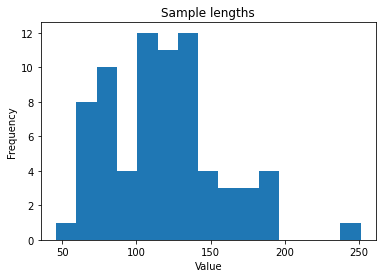

In [32]:
# Plot histogram of sample lengths
import matplotlib.pyplot as plt

lengths = []

for sample in tokenized_datasets["train"]["labels"]:
  lengths.append(len(sample))

plt.hist(lengths, bins=15)
plt.title('Sample lengths')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [33]:
print("Shortest sample length:", min(lengths))
print("Longest sample length:", max(lengths))

Shortest sample length: 46
Longest sample length: 251


We have to pad the tokens and the labels so that they have the same length.

In [34]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [35]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 73
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9
    })
})

This is an example of how the DataCollator would pad the samples if we passed in the whole dataset:

In [36]:
# For demonstration purposes, we pass in the whole "train" dataset
batch = data_collator(tokenized_datasets["train"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


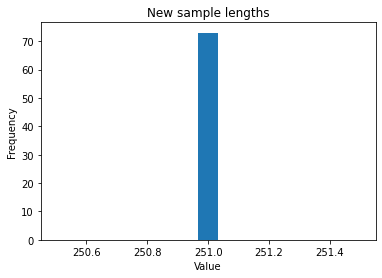

In [37]:
new_lengths = []

for sample in batch["labels"]:
  new_lengths.append(len(sample))

plt.hist(new_lengths, bins=15)
plt.title('New sample lengths')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [38]:
print("Shortest sample length (labels):", min(new_lengths))
print("Longest sample length (labels):", max(new_lengths))

Shortest sample length (labels): 251
Longest sample length (labels): 251


As we can see, all sample labels get padded to the length of the longest sample.

So do the input IDs:

In [39]:
input_ids_lengths = []

for sample in batch["input_ids"]:
  input_ids_lengths.append(len(sample))

print("Shortest sample length (input_ids):", min(input_ids_lengths))
print("Longest sample length (input_ids):", max(input_ids_lengths))

Shortest sample length (input_ids): 251
Longest sample length (input_ids): 251


In [40]:
# The input IDs get padded with 0s
batch["input_ids"][0]

tensor([  101,  1109,  1965,  3816,  1165,   170,  2261,  5622,  1200,  3471,
         1147,  3403,  1111,   170,  2261,   119,  1109,  2261,  5622,  1200,
         1169,  1173,  1844,  3209,  2261,  6305,  1105,  2561,   170,  2190,
         1104,  3209, 13673,   119,  1109,  2261,  5622,  1200,  1169,  1173,
         2519,  1149,  1106,  1103, 13673,  1113,  1103,  2190,  1106,  1107,
        15174,  1164,  1501,  3638,   119,  1409,  1126,  1501,  1700,  5903,
          117,  1103,  2261,  5622,  1200,  1169, 12295,  1147, 14926,  1105,
         2267,  2998,   119,  1109, 11440,  1169,  1173,  3189,  1103, 14926,
         1105,  2267,  2998,  1105,  4958,  2480,  1137,  1136,  1106, 13967,
         1103,  2261,  5622,  1200,  1111,  1126,  3669,   119,  1409,  1103,
         2383,  1110,  1106, 13967,   117,  1103,  2261,  5622,  1200,  1169,
         1173,  7034,  1111,  1103,  3669,  1105,  4739,  1103,  3669,   119,
         1258,  1103,  3669,   117,  1103, 11440,  1169,  4958, 

In [41]:
# The labels get padded with -100
batch["labels"][0]

tensor([-100,    0,    0,    0,    0,    1,    2,    2,    2,    3,    4,    4,
           4,    4,    4,    0,    1,    2,    2,    2,    0,    0,    3,    4,
           4,    4,    0,    3,    4,    4,    4,    4,    4,    0,    1,    2,
           2,    2,    0,    0,    3,    4,    4,    4,    4,    0,    0,    0,
           0,    3,    4,    4,    4,    4,    0,    0,    0,    0,    0,    0,
           0,    1,    2,    2,    2,    0,    3,    4,    4,    4,    4,    4,
           0,    1,    2,    0,    0,    3,    4,    4,    4,    4,    4,    0,
           3,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    0,    0,    0,    0,    0,    0,    0,    0,    1,    2,    2,
           2,    0,    0,    3,    4,    4,    4,    0,    3,    4,    4,    0,
           0,    0,    0,    0,    1,    2,    0,    3,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

# Fine-tuning

In [42]:
# Install library to evaluate token classification predictions
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=59504beb20558ec13267949febdcd1e3564dc455d0832f5d67e4006b94c6fac8
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval


In [43]:
import evaluate

metric = evaluate.load("seqeval")

Using seqeval with Hugging Face Evaluate: https://huggingface.co/spaces/evaluate-metric/seqeval

In [44]:
# seqeval demo
correct_labels = list(map(lambda x: id2label[x], updated_dataset_dict["train"][0]["labels"][:13]))
fake_preds = correct_labels.copy()
fake_preds[-4] = "O"

print("Correct labels:", correct_labels)
print("Fake predictions:", fake_preds)
print("\n")
metric.compute(predictions=[fake_preds], references=[correct_labels])

Correct labels: ['O', 'O', 'O', 'O', 'B-AGENT', 'I-AGENT', 'I-AGENT', 'B-TASK', 'I-TASK', 'I-TASK', 'I-TASK', 'I-TASK', 'I-TASK']
Fake predictions: ['O', 'O', 'O', 'O', 'B-AGENT', 'I-AGENT', 'I-AGENT', 'B-TASK', 'I-TASK', 'O', 'I-TASK', 'I-TASK', 'I-TASK']




{'AGENT': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'TASK': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.3333333333333333,
 'overall_recall': 0.5,
 'overall_f1': 0.4,
 'overall_accuracy': 0.9230769230769231}

In [45]:
# Defining an evaluation function

import numpy as np

def compute_metrics(eval_preds):
    
    logits, labels = eval_preds

    # Extract index of logit with maximum value (i.e. the predicted labels)
    predictions = np.argmax(logits, axis=-1)

    # Convert labels and predictions from integers to strings and remove special tokens (-100)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [46]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [47]:
model.config.num_labels

5

In [48]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [49]:
# Defining our training arguments

from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-bpmn",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=True,
)

In [50]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/jtlicardo/bert-finetuned-bpmn into local empty directory.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 73
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50
  Number of trainable parameters = 107723525


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.843653,0.189922,0.320261,0.238443,0.700540
2,No log,0.496653,0.542056,0.758170,0.632153,0.841727
3,No log,0.340300,0.671875,0.843137,0.747826,0.886691
4,No log,0.282114,0.692308,0.823529,0.752239,0.890288
5,No log,0.265599,0.731429,0.836601,0.780488,0.893885


***** Running Evaluation *****
  Num examples = 9
  Batch size = 8
Saving model checkpoint to bert-finetuned-bpmn/checkpoint-10
Configuration saved in bert-finetuned-bpmn/checkpoint-10/config.json
Model weights saved in bert-finetuned-bpmn/checkpoint-10/pytorch_model.bin
tokenizer config file saved in bert-finetuned-bpmn/checkpoint-10/tokenizer_config.json
Special tokens file saved in bert-finetuned-bpmn/checkpoint-10/special_tokens_map.json
tokenizer config file saved in bert-finetuned-bpmn/tokenizer_config.json
Special tokens file saved in bert-finetuned-bpmn/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 9
  Batch size = 8
Saving model checkpoint to bert-finetuned-bpmn/checkpoint-20
Configuration saved in bert-finetuned-bpmn/checkpoint-20/config.json
Model weights saved in bert-finetuned-bpmn/checkpoint-20/pytorch_model.bin
tokenizer config file saved in bert-finetuned-bpmn/checkpoint-20/tokenizer_config.json
Special tokens file saved in bert-finetuned-bpmn/

TrainOutput(global_step=50, training_loss=0.6322269439697266, metrics={'train_runtime': 49.1484, 'train_samples_per_second': 7.426, 'train_steps_per_second': 1.017, 'total_flos': 33379524614280.0, 'train_loss': 0.6322269439697266, 'epoch': 5.0})

In [51]:
trainer.push_to_hub()

Saving model checkpoint to bert-finetuned-bpmn
Configuration saved in bert-finetuned-bpmn/config.json
Model weights saved in bert-finetuned-bpmn/pytorch_model.bin
tokenizer config file saved in bert-finetuned-bpmn/tokenizer_config.json
Special tokens file saved in bert-finetuned-bpmn/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/411M [00:00<?, ?B/s]

Upload file runs/Dec10_16-02-31_0dfb9e6ee3eb/events.out.tfevents.1670688513.0dfb9e6ee3eb.76.0:  51%|#####1    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/jtlicardo/bert-finetuned-bpmn
   b2947ba..745e658  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/jtlicardo/bert-finetuned-bpmn
   b2947ba..745e658  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Token Classification', 'type': 'token-classification'}, 'metrics': [{'name': 'Precision', 'type': 'precision', 'value': 0.7314285714285714}, {'name': 'Recall', 'type': 'recall', 'value': 0.8366013071895425}, {'name': 'F1', 'type': 'f1', 'value': 0.7804878048780487}, {'name': 'Accuracy', 'type': 'accuracy', 'value': 0.8938848920863309}]}
To https://huggingface.co/jtlicardo/bert-finetuned-bpmn
   745e658..f38dd3f  main -> main

   745e658..f38dd3f  main -> main



'https://huggingface.co/jtlicardo/bert-finetuned-bpmn/commit/745e658bb2ddff3bfbc0d76cd2fea9debee6c1e9'